<a href="https://colab.research.google.com/github/igoravelli/brazilian_soccer_championship_analysis/blob/main/Number_of_matches_with_expelled_players.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install waterfall_ax

In [ ]:
# @title Imports & configs
import pandas as pd
import numpy as np
# import waterfall_chart

from waterfall_ax import WaterfallChart
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

import matplotlib.pyplot as plt
import seaborn as sns



data_table.enable_dataframe_formatter()
auth.authenticate_user()

project = 'brasileirao-362523'
schema = 'exp_brasileirao'
location = 'US'

client = bigquery.Client(project=project, location=location)

In [ ]:
# @title get fact_events
fact_events = client.query(f"""
      SELECT * FROM `{project}.{schema}.exp_fatoEventos`
    """).to_dataframe()

# fact_events.set_index('pk_fato', inplace=True)
fact_events.head()

,pk_fato,fk_id_partida,fk_id_time,fk_id_calendario,fk_id_jogador,fk_id_estadio,evento,minuto,acrescimo
0,2000001,4607,1268,20140419,14367,100104,gol,31,0
1,2000002,4607,1231,20140419,15053,100104,amarelo,44,0
2,2000003,4607,1268,20140419,11742,100104,gol,45,0
3,2000004,4607,1268,20140419,14030,100104,gol,59,0
4,2000005,4607,1231,20140419,14206,100104,amarelo,66,0


In [ ]:
# @title get dim_match
dim_match = client.query(f"""
      SELECT * FROM `{project}.{schema}.exp_dimPartida`
    """).to_dataframe()

dim_match.set_index('pk_partida', inplace=True)
dim_match.head()

,estadio,visitante,mandante,rodada,data_partida,ano_campeonato,formacao_mandante,formacao_visitante,vencedor,perdedor
pk_partida,,,,,,,,,,
1,100028,1476,1340,1,2003-03-29 16:00:00,2003,N/A,N/A,guarani,vasco
2,100012,1319,1013,1,2003-03-29 16:00:00,2003,N/A,N/A,athletico-pr,gremio
3,100104,1183,1245,1,2003-03-30 16:00:00,2003,N/A,N/A,None,None
4,100144,1392,1299,1,2003-03-30 16:00:00,2003,N/A,N/A,None,None
5,100023,1393,1341,1,2003-03-30 16:00:00,2003,N/A,N/A,None,None


In [ ]:
# @title get dim_time
dim_team = client.query(f"""
      SELECT * FROM `{project}.{schema}.exp_dimTime`
    """).to_dataframe()

dim_team.set_index('pk_time', inplace=True)
dim_team.head()

,nome,estado,arena,tecnico,start_id,end_id
pk_time,,,,,,
1225,csa,AL,estadio_rei_pele,M._Ribeiro_Cabo,6513,6589
1226,csa,AL,estadio_rei_pele,A._Fucks,6601,6861
1227,csa,AL,estadio_rei_pele,G._Santos_Vasconcelo,6869,6879
1079,bahia,BA,itaipava_arena_fonte_nova,N/A,8,4612
1080,bahia,BA,itaipava_arena_fonte_nova,M._dos_Santos_Goncalves,4623,4730


# Transformations

## Merge all dataframes

In [ ]:
all_infos = fact_events.merge(right = dim_team,
                              how = 'left',
                              left_on = 'fk_id_time',
                              right_on = 'pk_time').merge(right = dim_match,
                                                          how = 'left',
                                                          left_on = 'fk_id_partida',
                                                          right_on = 'pk_partida')

selc_cols = [
    'fk_id_partida',
    'fk_id_time',
    'nome',
    'visitante',
    'mandante',
    'vencedor',
    'perdedor',
    'evento',
    'minuto'
]

all_infos = all_infos[selc_cols].rename(columns = {'fk_id_partida': "match_id",
                                                   'fk_id_time': "team_id",
                                                   'nome': "team_name",
                                                   'evento': "event_name",
                                                   'minuto': "min",
                                                   'visitante': "visitor",
                                                   'mandante': "home_team",
                                                   'perdedor': "loser",
                                                   'vencedor': "winner"})

In [ ]:
all_infos.head()

,match_id,team_id,team_name,visitor,home_team,winner,loser,event_name,min
0,4607,1268,fluminense,1231,1268,fluminense,figueirense,gol,31
1,4607,1231,figueirense,1231,1268,fluminense,figueirense,amarelo,44
2,4607,1268,fluminense,1231,1268,fluminense,figueirense,gol,45
3,4607,1268,fluminense,1231,1268,fluminense,figueirense,gol,59
4,4607,1231,figueirense,1231,1268,fluminense,figueirense,amarelo,66


## Create flags

In [ ]:
all_infos['is_red_card_on_first_half'] = all_infos.apply(lambda x: x['event_name'] == 'vermelho' and x['min'] <= 45, axis=1)
all_infos.head(20)

,match_id,team_id,team_name,visitor,home_team,winner,loser,event_name,min,is_red_card_on_first_half
0,4607,1268,fluminense,1231,1268,fluminense,figueirense,gol,31,False
1,4607,1231,figueirense,1231,1268,fluminense,figueirense,amarelo,44,False
2,4607,1268,fluminense,1231,1268,fluminense,figueirense,gol,45,False
3,4607,1268,fluminense,1231,1268,fluminense,figueirense,gol,59,False
4,4607,1231,figueirense,1231,1268,fluminense,figueirense,amarelo,66,False
5,4608,1341,internacional,1504,1341,internacional,vitoria,gol,6,False
6,4608,1504,vitoria,1504,1341,internacional,vitoria,amarelo,10,False
7,4608,1341,internacional,1504,1341,internacional,vitoria,amarelo,20,False
8,4608,1341,internacional,1504,1341,internacional,vitoria,amarelo,72,False
9,4608,1504,vitoria,1504,1341,internacional,vitoria,amarelo,82,False


## Create norm column
This column indicate if the event is from winner or loser

In [ ]:
conditions = [
    all_infos['team_name'] == all_infos['loser'],
    all_infos['team_name'] == all_infos['winner'],
    all_infos['loser'].isnull()
]
choices = ['defeat', 'win', 'draw']

all_infos['norm'] = np.select(conditions, choices)

all_infos.loc[all_infos['is_red_card_on_first_half']].head()


,match_id,team_id,team_name,visitor,home_team,winner,loser,event_name,min,is_red_card_on_first_half,norm
88,4621,1246,flamengo,1246,1168,corinthians,flamengo,vermelho,42,True,defeat
150,4631,1232,figueirense,1232,1205,criciuma,figueirense,vermelho,30,True,defeat
324,4654,1206,criciuma,1342,1206,None,None,vermelho,43,True,draw
803,4721,1247,flamengo,1247,1342,internacional,flamengo,vermelho,45,True,defeat
850,4729,1206,criciuma,1507,1206,vitoria,criciuma,vermelho,38,True,defeat


In [ ]:
def is_sum_more_than_zero(col: pd.Series) -> bool:
    """Function to indicate with the sum of col values is more than zero
    Args:
        col: col with numeric values
    Returns:
        bool that indicates with the sum is more than zero
    """

    sum_vl = sum(col)

    return sum_vl > 0



grouped = all_infos.groupby(['match_id','norm'], as_index=False)\
                    .agg(cards_qnt=('is_red_card_on_first_half', is_sum_more_than_zero))\
                    .pivot(index='match_id', columns='norm', values='cards_qnt')\
                    .fillna(False)
grouped.head(20)

norm,defeat,draw,win
match_id,,,
4607,False,False,False
4608,False,False,False
4609,False,False,False
4610,False,False,False
4611,False,False,False
4612,False,False,False
4614,False,False,False
4615,False,False,False
4616,False,False,False


# Visualizations

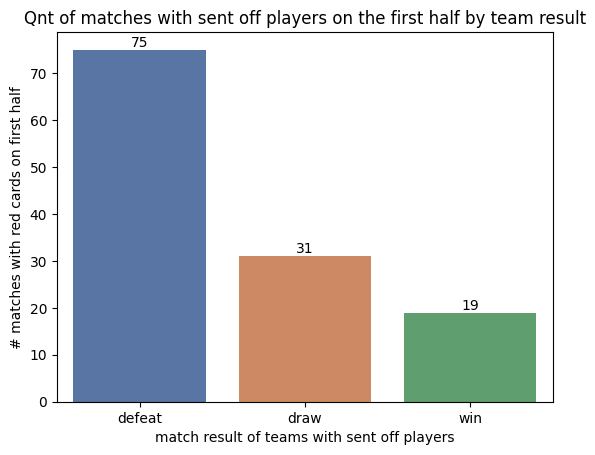

In [ ]:
to_plot = grouped.sum().reset_index()
to_plot.columns = [
    'match result of teams with sent off players',
    '# matches with red cards on first half'
]

# define Seaborn color palette to use
sns.set_palette('deep')
palette_color = sns.color_palette('deep')[0:3]

ax = sns.barplot(data = to_plot,
                 x = 'match result of teams with sent off players',
                 y = '# matches with red cards on first half')

plt.title('Qnt of matches with sent off players on the first half by team result')

ax.bar_label(ax.containers[0])
plt.show()

# Conclusion
As we can see on the chart above, when a team has an expelled player in the first half of the match, it loses it most of the time. To be precise, it happens almost 4x times more than to win the match.

Can be a nice strategy to play to draw the match when it happens,